In [121]:
%matplotlib inline
import torch


# get the device, either cuda or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('device type is {}'.format(device))

device type is cpu


In [122]:
import numpy as np
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, BatchNormalization, Flatten, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.fftpack import dct, idct
from scipy import signal

In [123]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [124]:
num_trials_train, num_electrodes_train, num_bins_train = X_train_valid.shape
num_trials_test, num_electrodes_test, num_bins_test = X_test.shape

y_test -= 769
y_train_valid -= 769
lb = preprocessing.LabelBinarizer()
lb.fit([0,1,2,3])
lb.classes_
y_train_valid= lb.transform(y_train_valid)
y_test = lb.transform(y_test)

In [125]:
downsampling_size = 25      
X_train_valid_ds = signal.resample(X_train_valid,downsampling_size,axis=2)
X_test_ds = signal.resample(X_test,downsampling_size,axis=2)

In [126]:
model = Sequential()

model.add(GRU(200, return_sequences=True, stateful=False,recurrent_dropout=0.8, dropout = 0, input_shape=(int(X_train_valid_ds.shape[2]),num_electrodes_train )))

model.add(GRU(100, return_sequences=True, stateful=False,recurrent_dropout=0.8, dropout = 0))

model.add(GRU(50, return_sequences=True, stateful=False,recurrent_dropout=0.8, dropout = 0))

# model.add(GRU(25, return_sequences=True, stateful=False, recurrent_dropout=0.8, dropout = 0))
model.add(Flatten())

model.add(Dense(100))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(4,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [127]:
m,n,q = X_train_valid_ds.shape
X_train_valid_dss = np.zeros([m,q,n])
for i in range(m):
    X_train_valid_dss[i] = np.transpose(X_train_valid_ds[i])
    
m,n,q = X_test_ds.shape
X_test_dss = np.zeros([m,q,n])
for i in range(m):
    X_test_dss[i] = np.transpose(X_test_ds[i])

In [128]:
history = model.fit(X_train_valid_dss, y_train_valid,batch_size=200, epochs=50, shuffle=True,validation_split = 0.05)
scores = model.evaluate(X_test_dss, y_test, verbose=0)


Epoch 1/50
11/11 [==============================] - 6s 231ms/step - loss: 1.5198 - accuracy: 0.3405 - val_loss: 1.2252 - val_accuracy: 0.4906
Epoch 2/50
11/11 [==============================] - 2s 175ms/step - loss: 1.2545 - accuracy: 0.4535 - val_loss: 1.1620 - val_accuracy: 0.5566
Epoch 3/50
11/11 [==============================] - 2s 160ms/step - loss: 1.1516 - accuracy: 0.5047 - val_loss: 1.1005 - val_accuracy: 0.5849
Epoch 4/50
11/11 [==============================] - 2s 189ms/step - loss: 1.0852 - accuracy: 0.5241 - val_loss: 1.0509 - val_accuracy: 0.6226
Epoch 5/50
11/11 [==============================] - 2s 168ms/step - loss: 1.0188 - accuracy: 0.5694 - val_loss: 1.0166 - val_accuracy: 0.6038
Epoch 6/50
11/11 [==============================] - 2s 186ms/step - loss: 0.9513 - accuracy: 0.6098 - val_loss: 1.0244 - val_accuracy: 0.6038
Epoch 7/50
11/11 [==============================] - 2s 185ms/step - loss: 0.9177 - accuracy: 0.6172 - val_loss: 0.9544 - val_accuracy: 0.6321
Epoch 

In [129]:
print("downsampling size: {}".format(downsampling_size))
print("testing accuracy: %.2f%%" % (scores[1]*100))
print("maximum validation accuracy: %.2f%%" % (max(history.history['val_accuracy'])*100))

downsampling size: 25
testing accuracy: 58.01%
maximum validation accuracy: 70.75%


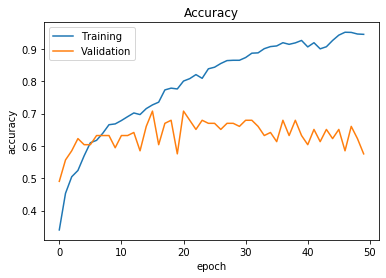

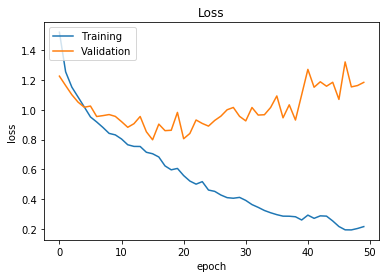

In [130]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()